In [2]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
import os, shutil
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

base_dir = os.path.join(str(Path.home()), 'projects', 'dlp', 'datasets', 'cats_and_dogs_small')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        feature_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i+1) * batch_size] = feature_batch
        labels[i * batch_size: (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.


Found 1000 images belonging to 2 classes.


In [6]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.


In [8]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim= 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 15ms/step - loss: 0.6049 - acc: 0.6750 - val_loss: 0.4581 - val_acc: 0.8290
Epoch 2/30
100/100 [==============================] - 1s 13ms/step - loss: 0.4409 - acc: 0.8010 - val_loss: 0.3747 - val_acc: 0.8710
Epoch 3/30
100/100 [==============================] - 1s 13ms/step - loss: 0.3703 - acc: 0.8460 - val_loss: 0.3354 - val_acc: 0.8790
Epoch 4/30
100/100 [==============================] - 1s 15ms/step - loss: 0.3195 - acc: 0.8725 - val_loss: 0.3075 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 1s 13ms/step - loss: 0.2855 - acc: 0.8755 - val_loss: 0.2918 - val_acc: 0.8900
Epoch 6/30
100/100 [==============================] - 1s 13ms/step - loss: 0.2751 - acc: 0.8850 - val_loss: 0.2862 - val_acc: 0.8790
Epoch 7/30
100/100 [==============================] - 1s 13ms/step - loss: 0.2592 - acc: 0.8975 - val_loss: 0.2703 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 1s 13ms/step - 

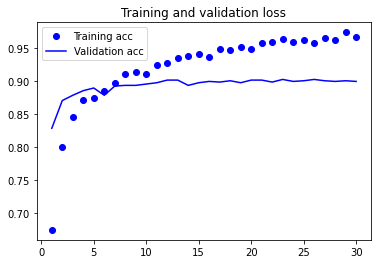

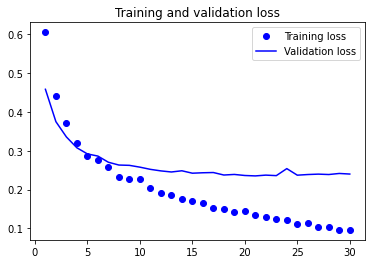

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title("Training and validation loss")
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()



In [31]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

print(f"Trainable weights: {len(model.trainable_weights)}")
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Trainable weights: 4


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [33]:
from tensorflow.keras import optimizers
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 347s 3s/step - loss: 0.5691 - acc: 0.7300 - val_loss: 0.4403 - val_acc: 0.8150
Epoch 2/30
 53/100 [==============>...............] - ETA: 1:45 - loss: 0.4960 - acc: 0.7764

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title("Training and validation loss")
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


In [36]:
import os, shutil
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

base_dir = os.path.join(str(Path.home()), 'projects', 'dlp', 'datasets', 'cats_and_dogs_small')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

batch_size = 20

def extract_features(datagen, directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        feature_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i+1) * batch_size] = feature_batch
        labels[i * batch_size: (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_features, train_labels = extract_features(train_datagen, train_dir, 3000)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_features, validation_labels = extract_features(validation_datagen, validation_dir, 1000)
test_datagen = ImageDataGenerator(rescale=1./255)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


TypeError: extract_features() missing 1 required positional argument: 'sample_count'

In [37]:
train_features = np.reshape(train_features, (3000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [38]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim= 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Epoch 1/30
150/150 [==============================] - 4s 29ms/step - loss: 0.6405 - acc: 0.6307 - val_loss: 0.4601 - val_acc: 0.8250
Epoch 2/30
150/150 [==============================] - 4s 28ms/step - loss: 0.5092 - acc: 0.7453 - val_loss: 0.3867 - val_acc: 0.8450
Epoch 3/30
150/150 [==============================] - 4s 28ms/step - loss: 0.4389 - acc: 0.7950 - val_loss: 0.3374 - val_acc: 0.8760
Epoch 4/30
150/150 [==============================] - 5s 32ms/step - loss: 0.4095 - acc: 0.8033 - val_loss: 0.3123 - val_acc: 0.8730
Epoch 5/30
150/150 [==============================] - 5s 34ms/step - loss: 0.3809 - acc: 0.8357 - val_loss: 0.2997 - val_acc: 0.8830
Epoch 6/30
150/150 [==============================] - 5s 30ms/step - loss: 0.3542 - acc: 0.8443 - val_loss: 0.2857 - val_acc: 0.8850
Epoch 7/30
150/150 [==============================] - 5s 31ms/step - loss: 0.3386 - acc: 0.8583 - val_loss: 0.2783 - val_acc: 0.8910
Epoch 8/30
150/150 [==============================] - 5s 30ms/step - 

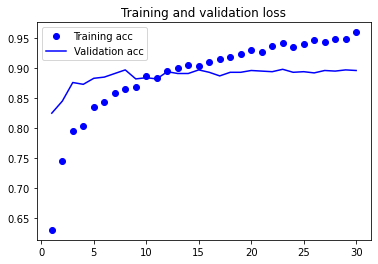

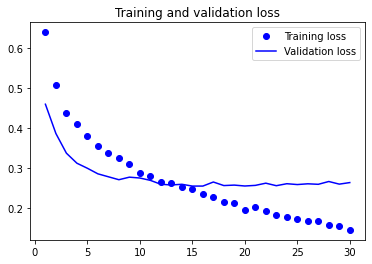

In [39]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title("Training and validation loss")
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()
